# Weighted Least Squares

#### By: Jonathan Johannemann

Below is just a notebook of me taking a look at weighted least squares. I've decided to combine commentary from the actual notebook with my own explanation for what weighted least squares achieves.

In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)
%matplotlib inline

In the statsmodels notebook, they don't really talk too much about what Weighted Least Squares actually is. Therefore, I decided to take some of the things I learned from reading https://onlinecourses.science.psu.edu/stat501/node/352.

## First, let's take a look at how WLS differs from OLS

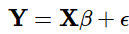

In [2]:
Image(filename='Pictures/ols_formula.png')

As seen above, we see the equation for OLS. Following this, we want to find a beta as shown below.

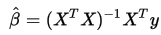

In [3]:
Image(filename='Pictures/beta_formula.png')

Okay, now we are going to consider e. What weighted least squares basically says is that points on the regression with less variance have more information than points on the regression that have higher variance. This phenomenon is known as heteroscedasticity when the variance of the linear regression residuals are not consistent. For the error term, we usually assume that the errors are normally distributed with mean vector 0 and now we have a nonconstant variance-covariance matrix. This is shown below.

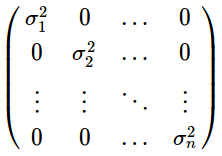

In [4]:
Image(filename='Pictures/nonconstant_var_cov_mat.png')

The next part is the essence of weighted least squares.

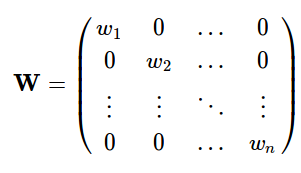

In [5]:
Image(filename='Pictures/w_mat.png')

The w values shown above are equal to 1/[variance value in that column in the matrix above].

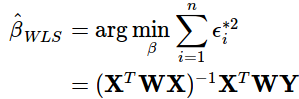

In [6]:
Image(filename='Pictures/wls.png')

As shown above, weighted least squares uses the inverse of the variance to weight values. We can see that weighted least squares simply incorporates the variance of the corresponding error values.

The observations below now follow and this is taken directly from Penn Stat 501:
* Since each weight is inversely proportional to the error variance, it reflects the information in that observation. So, an observation with small error variance has a large weight since it contains relatively more information than an observation with large error variance (small weight).
* The weights have to be known (or more usually estimated) up to a proportionality constant.

## WLS Estimation

### Artificial data: Heteroscedasticity 2 groups 

Model assumptions:

 * Misspecification: true model is quadratic, estimate only linear
 * Independent noise/error term
 * Two groups for error variance, low and high variance groups

In [7]:
nsample = 50
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e 
X = X[:,[0,1]]

So the guys at statsmodels decided to introduce a situation where WLS is better than OLS. We can see that the real function is not linear and the error terms get larger towards the end.

Okay, let's start with OLS.

In [8]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     347.7
Date:                Sun, 25 Dec 2016   Prob (F-statistic):           1.25e-23
Time:                        22:12:36   Log-Likelihood:                -68.470
No. Observations:                  50   AIC:                             140.9
Df Residuals:                      48   BIC:                             144.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2426      0.271     19.370      0.0

We can see that the x1 variable has a significant t value and seems to do a fairly good job with a good Adj. R-squared value of 0.783. Now let's see how WLS compares to OLS when WLS knows the true variance ratio of heteroscedasticity.

In [9]:
mod_wls = sm.WLS(y, X, weights=1./w)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            WLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     487.9
Date:                Sun, 25 Dec 2016   Prob (F-statistic):           8.52e-27
Time:                        22:12:37   Log-Likelihood:                -57.048
No. Observations:                  50   AIC:                             118.1
Df Residuals:                      48   BIC:                             121.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2726      0.185     28.488      0.0

We can clearly see a difference between the two models. The t statistic for x1 is more significant with WLS and the Adj. R-Squared is even higher at 0.842.

In [10]:
print(res_ols.params)
print(res_wls.params)

[ 5.24256099  0.43486879]
[ 5.27260714  0.43794441]


As a quick model comparison, we can see that WLS does not change the model too dramatically in this example. But, it is clear that the WLS model is pushing more emphasis to the x1 value as opposed to the intercept which can be observed in the OLS model.

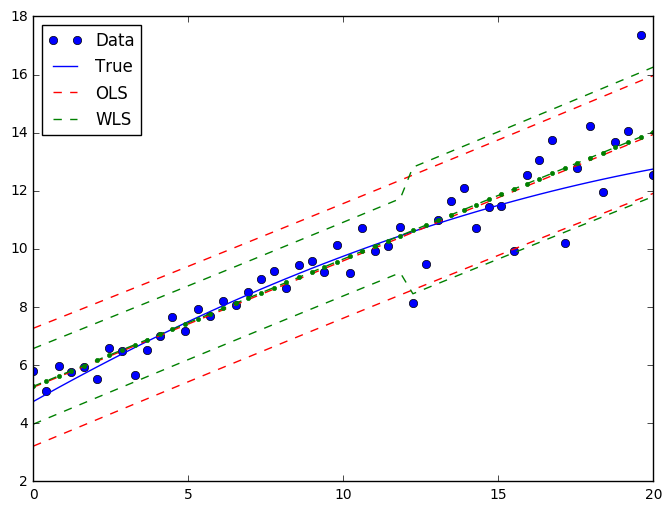

In [11]:
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb,X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="OLS")
ax.plot(x, iv_l_ols, 'r--')
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_u, 'g--', label="WLS")
ax.plot(x, iv_l, 'g--')
ax.legend(loc="best");

Above, we can see how the confidence intervals changes with WLS once we hit the portion of data that has a higher variance. WLS posits that the first segment of data points offers more information than the latter. However, when we know that the assumption of homoscedasticity in OLS has been violated, we need to make sure to double check WLS when estimates are being made. Clearly, we have a higher confidence in our predictions in the first segment as opposed to the later segment that has more variance.

## What is Feasible Weighted Least Squares? (2-stage FWLS)

Instead of minimizing with respect to an estimated variance-covariance matrix W where the off diagonal values are 0. Feasible Weighted Least Squares, also known as "General Least Squares" from what I've seen so far, optimizes with respect to the Mahalanobis distance. The reason that GLS is often helpful is because it is very difficult to come up with the W matrix in practice.

In [12]:
resid1 = res_ols.resid[w==1.]
var1 = resid1.var(ddof=int(res_ols.df_model)+1)
resid2 = res_ols.resid[w!=1.]
var2 = resid2.var(ddof=int(res_ols.df_model)+1)
w_est = w.copy()
w_est[w!=1.] = np.sqrt(var2) / np.sqrt(var1)
res_fwls = sm.WLS(y, X, 1./w_est).fit()
print(res_fwls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            WLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     507.1
Date:                Sun, 25 Dec 2016   Prob (F-statistic):           3.65e-27
Time:                        22:21:17   Log-Likelihood:                -55.777
No. Observations:                  50   AIC:                             115.6
Df Residuals:                      48   BIC:                             119.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2710      0.177     29.828      0.0

As we can see, the performance is even better than that of normal WLS (the difficult to implement in practice scenario). The Feasible WLS model provides an Adj. R-squared of 0.912 which is the best so far. Of course, these are just preliminary model evaluations and require cross validation sets; but, we can see that it does appear that Feasible WLS does the best out of these three models.

So, what does the beta look like? (Assuming that we are right that this is GLS) Like this:

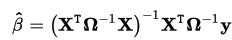

In [13]:
Image(filename="Pictures/gls.png")

What's the benefit of GLS? The GLS estimator is unbiased, consistent, efficient, and asymptotically normal. (Wikipedia's words)